### Assignment 3

Yingnan Zhao 260563769

In [1]:
import collections
import csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
import warnings; warnings.simplefilter('ignore')

#### Question 1

In [2]:
def preprocessing(data):
    df = pd.read_csv(data, sep='delimiter', header=None, engine='python')
    df = df[0]
    for i in range(len(df)):
        df[i] = re.sub(r'[^\w]', ' ', str.lower(df[i]))
    return df

In [3]:
def buildVocabulary(dataset, storageLocation):  # 'datasets//yelp-vocab.csv'
    dataset = preprocessing(dataset)
    topWords = collections.Counter()
    for comments in dataset:
        words = comments.split()[:-1]
        topWords.update(words)
    topWords = topWords.most_common(10000)
    Vocabulary = {}
    with open(storageLocation, 'w', newline='') as csvfile:
        csvWriter = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for j in range(len(topWords)):
            csvWriter.writerow([topWords[j][0], j, topWords[j][1]])
            Vocabulary[topWords[j][0]] = ((j, topWords[j][1]))
    return Vocabulary

In [4]:
def buildReview(dataset, vocabulary,storageLocation):
    dataset = preprocessing(dataset)
    reviews = []
    scores = []
    for comment in dataset:
        words = comment.split()
        row = []
        for k in range(len(words)-1):
            res = vocabulary.get(words[k],-1)
            if (res != -1):
                row.append(res[0])
        if(len(row)>0):
            reviews.append(row)
            scores.append(words[len(words)-1])
    with open(storageLocation, 'w', newline='') as csvfile:
        csvWriter = csv.writer(csvfile, delimiter=' ')
        for j in range(len(reviews)):
            row = []
            for i in range(len(reviews[j])):
                row.append(reviews[j][i])
            row.append('\t'+scores[j])
            csvWriter.writerow(row)
    return (reviews,scores)

In [5]:
def readReviews(reviewPath):
    df = pd.read_csv(reviewPath, sep='\t',names=['review','score'], engine='python')
    review = []
    for line in df['review']:
        row = line.split()
        review.append(np.array(row).astype(np.float))
    score = np.array(df['score']).astype(np.float)
    return (review,score)

In [6]:
def getBinaryBagOfWord(reviews):
    row = []
    col = []
    value = []
    length = len(reviews)
    for i in range(len(reviews)):
        temp = set()
        for j in range(len(reviews[i])):
            if(reviews[i][j] not in temp):
                temp.add(reviews[i][j])
                col.append(reviews[i][j])
                row.append(i)
                value.append(1)
    BBWMatrix = sparse.bsr_matrix((value, (row, col)))
    if(BBWMatrix.shape[1]!=10000):
        BBWMatrix = sparse.bsr_matrix((BBWMatrix.data, BBWMatrix.indices, BBWMatrix.indptr),shape=(length, 10000))
    # BBWMatrix = BBWMatrix.toarray()
    return BBWMatrix

In [7]:
def getFreqBagOfWord(reviews):
    row = []
    col = []
    value = []
    for i in range(len(reviews)):
        temp = []
        tempValue = []
        for j in range(len(reviews[i])):
            if(reviews[i][j] not in temp):
                temp.append(reviews[i][j])
                col.append(reviews[i][j])
                row.append(i)
                tempValue.append(1/len(reviews[i]))
            else:
                k = temp.index(reviews[i][j])
                tempValue[k]+=1/len(reviews[i])
        value += tempValue
    FBWMatrix = sparse.bsr_matrix((value, (row, col)))
    if (FBWMatrix.shape[1]!=10000):
        FBWMatrix = sparse.bsr_matrix((FBWMatrix.data, FBWMatrix.indices, FBWMatrix.indptr), shape=(len(reviews), 10000))
    # FBWMatrix = FBWMatrix.toarray()
    return FBWMatrix

In [8]:
def randomClassifier(trainingX,trainingY,testingX,testingY):
    clfUniform = DummyClassifier(strategy='uniform',random_state=0)
    clfUniform.fit(trainingX, trainingY)
    preditYUniform = []
    for i in range(len(testingX)):
        ans1 = clfUniform.predict([testingX[i]])
        preditYUniform.append(ans1)
    print('Uniform Random F1 Score= ' + str(metrics.f1_score(testingY, preditYUniform, average='weighted')))
def mostFrequentClassifier(trainingX,trainingY,testingX,testingY):
    clfUniform = DummyClassifier(strategy='uniform',random_state=0)
    clfUniform.fit(trainingX, trainingY)
    preditYUniform = []
    for i in range(len(testingX)):
        ans1 = clfUniform.predict([testingX[i]])
        preditYUniform.append(ans1)
    print('Uniform Random F1 Score= ' + str(metrics.f1_score(testingY, preditYUniform, average='weighted')))

get the yelp train set and validation data set ready in binary bag of words representation

In [62]:
trainResult = readReviews('outputdatasets//yelp-train.txt')
trainX = getBinaryBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//yelp-valid.txt')
testX = getBinaryBagOfWord(testResult[0]).toarray()
testY = testResult[1]

set the baseline using the random classifier and the majority classifier

In [64]:
mostFrequentClassifier(trainX,trainY,testX,testY)
randomClassifier(trainX,trainY,testX,testY)

Uniform Random F1 Score= 0.13846153846153844
Uniform Random F1 Score= 0.13846153846153844


In [65]:
def plotHyperparameterTrainingProgress(input):
    a = np.array(input,dtype='float')
    a = np.transpose(a)
    plt.plot(a[1], a[0], 'bo')
    plt.title('Selecting HyperParameter')
    plt.xlabel('Hyperparameter')
    plt.ylabel('F1 Score')
    plt.show()

Find the optimal number of leaf

In [9]:
def decisionTree(trainingX, trainingY, testingX, testingY, maxLeaf,min_samples_split, max_features):
    clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=maxLeaf, min_samples_split = min_samples_split)
    clf.fit(trainingX, trainingY)
    preditY = []
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        preditY.append(ans)
    f1Score = metrics.f1_score(testingY, preditY, average='weighted')
    return f1Score

In [21]:
f1s = []
for i in range (300,100,-10):
    max_features = 1.0
    for j in range(10):
        max_features -= 0.05
        min_sample_split =0.01
        for k in range (10):
            min_sample_split *= 0.5
            f1s.append([decisionTree(trainX,trainY,testX,testY,i,min_sample_split,max_features),i,min_sample_split,max_features])
f1s.sort()
print('the optimal number of leafs is '+str(f1s[len(f1s)-1][1])+', min sample split is:'
      + str(f1s[len(f1s)-1][2]) +', max features is :'+str(f1s[len(f1s)-1][3])+', it achieves a F1 score of '+ str(f1s[len(f1s)-1][0]))

the optimal number of leafs is 200, min sample split is:0.005, max features is :0.95, it achieves a F1 score of 0.380983427942


Bernoulli Native Bayes

In [66]:
def BernoulliNativeBayes(trainingX,trainingY,testingX,testingY,a):
    clf = BernoulliNB(alpha=a)
    clf.fit(trainingX, trainingY)
    preditY = []
    hit = 0
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        if ans == testingY[i]:
            hit +=1
        preditY.append(ans)
    f1 = metrics.f1_score(testingY, preditY, average='weighted')
    # print('F1 Score = ' + str(f1))
    return f1

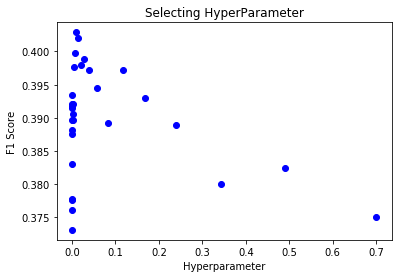

the optimal alpha is 0.009688901040699992, it achieves a F1 score of 0.4028932560404406


In [67]:
f1s = []
a = 1
for i in range(0,30):

    a *=0.7
    # print('alpha = '+str(a))
    f1s.append([BernoulliNativeBayes(trainX, trainY, testX, testY, a), a])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal alpha is ' + str(f1s[len(f1s)-1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s)-1][0]))

Linear SVM

In [68]:
def LinearSVM(trainingX, trainingY, testingX, testingY, C,dual):
    clf = LinearSVC(C=C,dual=dual)
    clf.fit(trainingX, trainingY)
    preditY = []
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        preditY.append(ans)
    f1Score = metrics.f1_score(testingY, preditY, average='weighted')
    return f1Score

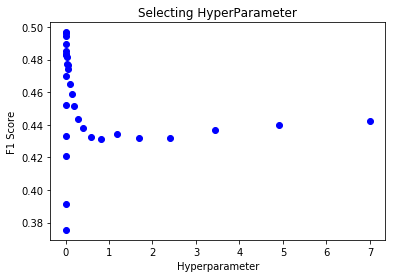

the optimal C is 0.007979226629761192, it achieves a F1 score of 0.4967606230498824


In [59]:
C = 10
f1s=[]
for i in range(0, 30):
    C  *= 0.7
    # print('alpha = '+str(a))
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,True), C])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))

### Question 3

In [15]:
trainResult = readReviews('outputdatasets//yelp-train.txt')
trainX = getFreqBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//yelp-valid.txt')
testX = getFreqBagOfWord(testResult[0]).toarray()
testY = testResult[1]

In [16]:
f1s = []
for i in range (300,100,-10):
    max_features = 1.0
    for j in range(10):
        max_features -= 0.05
        min_sample_split =0.01
        for k in range (10):
            min_sample_split *= 0.5
            f1s.append([decisionTree(trainX,trainY,testX,testY,i,min_sample_split,max_features),i,min_sample_split,max_features])
f1s.sort()
print('the optimal number of leafs is '+str(f1s[len(f1s)-1][1])+', min sample split is:'
      + str(f1s[len(f1s)-1][2]) +', max features is :'+str(f1s[len(f1s)-1][3])+', it achieves a F1 score of '+ str(f1s[len(f1s)-1][0]))

the optimal number of leafs is 110, min sample split is:0.0025, max features is :0.95, it achieves a F1 score of 0.37382611446735314


In [70]:
def NativeBayesGaussian(trainingX, trainingY, testingX, testingY):
    clf = GaussianNB()
    clf.fit(trainingX.toarray(), trainingY)
    preditY = []
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        preditY.append(ans)
    f1 = metrics.f1_score(testingY, preditY, average='weighted')
    return f1

In [71]:
print('Using Gaussian Native Bayes it achieves a F1 score of ' +str(NativeBayesGaussian(trainX, trainY, testX, testY)))

Using Gaussian Native Bayes it achieves a F1 score of 0.2996177961851601


yelp freq bag of words svm

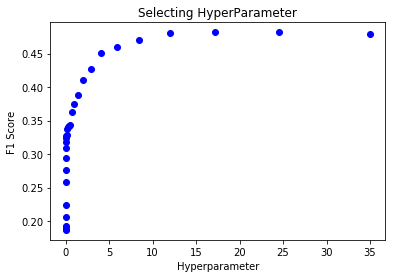

the optimal C is 17.15, it achieves a F1 score of 0.48178218374072873


In [72]:
C = 50
f1s=[]
for i in range(0, 30):
    C *=0.7
    # print('alpha = '+str(a))
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,True), C])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))

### Question4

In [12]:
trainResult = readReviews('outputdatasets//IMDB-train.txt')
trainX = getBinaryBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//IMDB-valid.txt')
testX = getBinaryBagOfWord(testResult[0]).toarray()
testY = testResult[1]

imdb binary tree

imdb binary Native Bayes

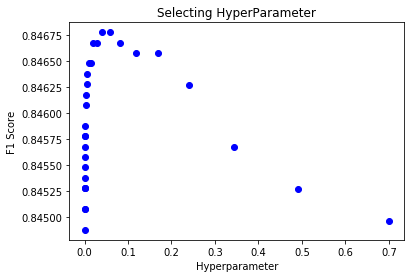

the optimal alpha is 0.04035360699999998, it achieves a F1 score of 0.8467741048237153


In [81]:
f1s = []
a = 1
for i in range(0,30):

    a *=0.7
    # print('alpha = '+str(a))
    f1s.append([BernoulliNativeBayes(trainX, trainY, testX, testY, a), a])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal alpha is ' + str(f1s[len(f1s)-1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s)-1][0]))

imdb binary SVM

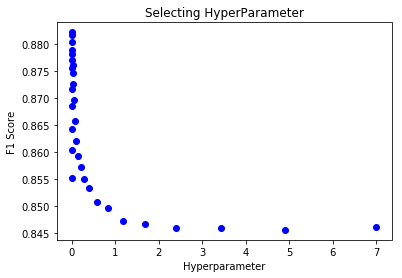

the optimal C is 0.005585458640832834, it achieves a F1 score of 0.8821900285640178


In [82]:
C = 10
f1s=[]
for i in range(0, 30):
    C  *= 0.7
    # print('alpha = '+str(a))
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,False), C])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))

In [83]:
trainResult = readReviews('outputdatasets//IMDB-train.txt')
trainX = getFreqBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//IMDB-valid.txt')
testX = getFreqBagOfWord(testResult[0]).toarray()
testY = testResult[1]

imdb freq tree

imdb freq Native Bayes

In [84]:
print('Using Gaussian Native Bayes it achieves a F1 score of ' +str(NativeBayesGaussian(trainX, trainY, testX, testY)))

Using Gaussian Native Bayes it achieves a F1 score of 0.7526517355819135


imdb freq svm

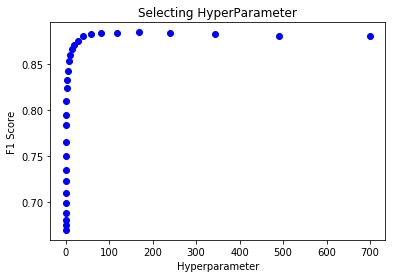

the optimal C is 168.06999999999994, it achieves a F1 score of 0.8842964999691241


In [88]:
C = 1000
f1s=[]
for i in range(0, 30):
    C *=0.7
    # print('alpha = '+str(a))
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,False), C])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))